# Universidad del Valle de Guatemala
## Facultad de Ingeniería
### Departamento de Computación

---

# Laboratorio 3: Deep Learning

**Integrantes:**
- Diego Alexander Hernández Silvestre, 21270
- Linda Inés Jiménez Vides, 21169

**Curso:** Data Science  
**Sección:** 10  

---

Guatemala, 08 de agosto de 2024


<div style="text-align: center;">
    <h1>✍️ Discusión / Cálculos - [Deep Learning] ✍️</h1>
</div>

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Input
from keras.models import Model
import os
import json

%matplotlib inline

### 📚 Carga de datasets 

In [70]:
csvPath = 'Consumo/dataConsumo.csv'
dataConsumo = pd.read_csv(csvPath)
print(f"✅ Archivo cargado: {csvPath}")

csvPath = 'Importacion/dataImportacion.csv'
dataImportacion = pd.read_csv(csvPath)
print(f"✅ Archivo cargado: {csvPath}")

csvPath = 'PreciosPromedioNacionales/dataPrecios.csv'
dataPrecios = pd.read_csv(csvPath)
print(f"✅ Archivo cargado: {csvPath}")

✅ Archivo cargado: Consumo/dataConsumo.csv
✅ Archivo cargado: Importacion/dataImportacion.csv
✅ Archivo cargado: PreciosPromedioNacionales/dataPrecios.csv


In [71]:
serieConsumoDiesel = dataConsumo[['Fecha', 'Diesel']]
serieImportacionRegular = dataImportacion[['Fecha', 'Gasolina regular']]
seriePreciosSuper = dataPrecios[['FECHA', 'Superior GTQ/GALON']]
serieConsumoDiesel.set_index('Fecha', inplace=True)
serieConsumoDiesel.sort_index(inplace=True)
serieImportacionRegular.set_index('Fecha', inplace=True)
serieImportacionRegular.sort_index(inplace=True)
seriePreciosSuper.set_index('FECHA', inplace=True)
seriePreciosSuper.sort_index(inplace=True)

In [72]:
def pruebaDickeyFuller(serieTiempo, descripcion):
    print(f"📊 Prueba de Dickey-Fuller Aumentada para: {descripcion}")
    resultado = adfuller(serieTiempo)
    print(f'Estadístico ADF: {resultado[0]}')
    print(f'p-valor: {resultado[1]}')
    print('Valores críticos:')
    for key, value in resultado[4].items():
        print(f'  {key}: {value}')
    print('-----------------------------------------------------')
    return resultado[1] 

print('-----------------------------------------------------')
pruebaDickeyFuller(serieConsumoDiesel['Diesel'], 'Diesel')
pruebaDickeyFuller(serieImportacionRegular['Gasolina regular'], 'Regular')
pruebaDickeyFuller(seriePreciosSuper['Superior GTQ/GALON'], 'Superior')

-----------------------------------------------------
📊 Prueba de Dickey-Fuller Aumentada para: Diesel
Estadístico ADF: 0.14523982117810716
p-valor: 0.9690175028779467
Valores críticos:
  1%: -3.453922368485787
  5%: -2.871918329081633
  10%: -2.5723001147959184
-----------------------------------------------------
📊 Prueba de Dickey-Fuller Aumentada para: Regular
Estadístico ADF: 0.8288289928204905
p-valor: 0.992087554110633
Valores críticos:
  1%: -3.4547128138328875
  5%: -2.8722649771800155
  10%: -2.5724850011573914
-----------------------------------------------------
📊 Prueba de Dickey-Fuller Aumentada para: Superior
Estadístico ADF: -2.9399220843939617
p-valor: 0.040898674582741115
Valores críticos:
  1%: -3.435401880796999
  5%: -2.863770985550096
  10%: -2.567957791647768
-----------------------------------------------------


0.040898674582741115

In [73]:
def detectar_valores_invalidos(serieTemporal, descripcion):
    serieTemporal = pd.to_numeric(serieTemporal, errors='coerce')  # Convertir a numérico y forzar NaN si hay errores
    n_nan = serieTemporal.isna().sum()
    n_no_positivos = (serieTemporal <= 0).sum()

    print(f"🔍 Detección de valores inválidos en la serie: {descripcion}")
    print(f"  Valores NaN: {n_nan}")
    print(f"  Valores no positivos: {n_no_positivos}")
    
    serieTemporal_sin_nan = serieTemporal.dropna()
    print(f"  Serie temporal sin valores NaN tiene {len(serieTemporal_sin_nan)} elementos.")
    
    return serieTemporal_sin_nan, n_nan, n_no_positivos

def varianza_estable(serieTemporal):
    n = len(serieTemporal)
    partes = np.array_split(serieTemporal, 3)
    varianzas = [np.var(parte) for parte in partes]
    return np.allclose(varianzas[0], varianzas[1], rtol=0.1) and np.allclose(varianzas[1], varianzas[2], rtol=0.1)

def aplicar_transformacion_logaritmica(serieTemporal):
    if (serieTemporal > 0).all():
        return np.log(serieTemporal)
    else:
        print("⚠️ La serie contiene valores no positivos, no se puede aplicar la transformación logarítmica.")
        return serieTemporal

def analizar_y_transformar_serie(serieTemporal, descripcion):
    print(f"🔍 Analizando la serie: {descripcion}")
    
    serieTemporal, n_nan, n_no_positivos = detectar_valores_invalidos(serieTemporal, descripcion)
    
    estacionaria = False
    intentos = 0
    max_intentos = 10

    serieTemporal = aplicar_transformacion_logaritmica(serieTemporal)
    
    while not estacionaria and intentos < max_intentos:
        intentos += 1
        p_valor = pruebaDickeyFuller(serieTemporal, descripcion)
        if p_valor < 0.05:
            if varianza_estable(serieTemporal):
                estacionaria = True
                print(f"✅ La serie {descripcion} es estacionaria en media y varianza.")
                break
            else:
                print(f"❌ La varianza no es estable en la serie {descripcion}.")
        else:
            print(f"❌ La serie {descripcion} no es estacionaria (p-valor: {p_valor}).")
        
        serieTemporal = serieTemporal.diff().dropna()
        print(f"🔄 Aplicando diferenciación a {descripcion}. Intento {intentos}.")
    
    if not estacionaria:
        print(f"⚠️ No se pudo hacer la serie {descripcion} estacionaria después de {max_intentos} intentos.")
        print("📈 Utilizando un modelo ARIMA para tratar con la no estacionariedad.")
        modelo_arima = ARIMA(serieTemporal, order=(1, 1, 1))
        modelo_arima_fit = modelo_arima.fit()
        print(modelo_arima_fit.summary())
    else:
        modelo_arima_fit = None
        
    return serieTemporal, modelo_arima_fit

# Asegúrate de que estas variables estén definidas correctamente
# Reemplaza con tus series temporales reales
serieTemporalD, modelo_arima_diesel = analizar_y_transformar_serie(serieConsumoDiesel['Diesel'], 'Diesel')
# print("--------------------------------------------------------------------------------------------------------")
serieTemporalR, modelo_arima_regular = analizar_y_transformar_serie(serieImportacionRegular['Gasolina regular'], 'Regular')
# print("--------------------------------------------------------------------------------------------------------")
serieTemporalS, modelo_arima_super = analizar_y_transformar_serie(seriePreciosSuper['Superior GTQ/GALON'], 'Superior')


🔍 Analizando la serie: Diesel
🔍 Detección de valores inválidos en la serie: Diesel
  Valores NaN: 0
  Valores no positivos: 0
  Serie temporal sin valores NaN tiene 293 elementos.
📊 Prueba de Dickey-Fuller Aumentada para: Diesel
Estadístico ADF: -0.44918144412882166
p-valor: 0.901557753919378
Valores críticos:
  1%: -3.453922368485787
  5%: -2.871918329081633
  10%: -2.5723001147959184
-----------------------------------------------------
❌ La serie Diesel no es estacionaria (p-valor: 0.901557753919378).
🔄 Aplicando diferenciación a Diesel. Intento 1.
📊 Prueba de Dickey-Fuller Aumentada para: Diesel
Estadístico ADF: -6.9885899777221345
p-valor: 7.851113111171977e-10
Valores críticos:
  1%: -3.453922368485787
  5%: -2.871918329081633
  10%: -2.5723001147959184
-----------------------------------------------------
❌ La varianza no es estable en la serie Diesel.
🔄 Aplicando diferenciación a Diesel. Intento 2.
📊 Prueba de Dickey-Fuller Aumentada para: Diesel
Estadístico ADF: -9.12656830456

### 🧪 Division train y test

In [74]:
# Dividir los datos en 70% entrenamiento, 15% validación y 15% prueba
def dividir_datos(serie, train_size=0.7, val_size=0.15):
    n = len(serie)
    train_end = int(n * train_size)
    val_end = int(n * (train_size + val_size))
    
    train = serie[:train_end]
    val = serie[train_end:val_end]
    test = serie[val_end:]
    
    return train, val, test

In [75]:
def supervisada(serie, retrasos=1):
    serie_x = []
    serie_y = []
    for i in range(len(serie) - retrasos):
        valor = serie[i:(i + retrasos), 0]
        valor_sig = serie[i + retrasos, 0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)


In [76]:
def toDataframe(serie):
    if not isinstance(serie, pd.DataFrame):
        print("📝 Convirtiendo a DataFrame")
        return serie.to_frame()
    return serie

In [77]:
# Preparar y escalar datos
scaler = StandardScaler()

# Diesel
print("⛽ Preparando datos Diesel")
serieTemporalD = toDataframe(serieTemporalD)
serieTemporalDScaled = scaler.fit_transform(serieTemporalD)
serieTemporalDScaled = pd.DataFrame(serieTemporalDScaled, index=serieTemporalD.index, columns=serieTemporalD.columns)

trainL3D, valL3D, testL3D = dividir_datos(serieTemporalDScaled)

x_trainD, y_trainD = supervisada(trainL3D.values)
x_valD, y_valD = supervisada(valL3D.values)
x_testD, y_testD = supervisada(testL3D.values)

# Gasolina Regular
print("⛽ Preparando datos Gasolina Regular")
serieTemporalR = toDataframe(serieTemporalR)
serieTemporalRScaled = scaler.fit_transform(serieTemporalR)
serieTemporalRScaled = pd.DataFrame(serieTemporalRScaled, index=serieTemporalR.index, columns=serieTemporalR.columns)

trainL3R, valL3R, testL3R = dividir_datos(serieTemporalRScaled)

x_trainR, y_trainR = supervisada(trainL3R.values)
x_valR, y_valR = supervisada(valL3R.values)
x_testR, y_testR = supervisada(testL3R.values)

# Gasolina Superior
print("⛽ Preparando datos Gasolina Superior")
serieTemporalS = toDataframe(serieTemporalS)
serieTemporalSScaled = scaler.fit_transform(serieTemporalS)
serieTemporalSScaled = pd.DataFrame(serieTemporalSScaled, index=serieTemporalS.index, columns=serieTemporalS.columns)

trainL3S, valL3S, testL3S = dividir_datos(serieTemporalSScaled)

x_trainS, y_trainS = supervisada(trainL3S.values)
x_valS, y_valS = supervisada(valL3S.values)
x_testS, y_testS = supervisada(testL3S.values)


⛽ Preparando datos Diesel
📝 Convirtiendo a DataFrame
⛽ Preparando datos Gasolina Regular
📝 Convirtiendo a DataFrame
⛽ Preparando datos Gasolina Superior
📝 Convirtiendo a DataFrame


### 🌀 Transformando a 3D

In [78]:
# Función para transformar matrices 2D en matrices 3D para LSTM
def transformar_a_3D(x):
    return np.reshape(x, (x.shape[0], 1, 1))

# Usando la función en los conjuntos de datos
def preparar_datos_lstm(x_train, y_train, x_val, y_val, x_test, y_test):
    print("🌀 Transformando a 3D...")    
    x_train_3D = transformar_a_3D(x_train)
    x_val_3D = transformar_a_3D(x_val)
    x_test_3D = transformar_a_3D(x_test)
    
    return x_train_3D, y_train, x_val_3D, y_val, x_test_3D, y_test

# Diesel
x_trainD_3D, y_trainD, x_valD_3D, y_valD, x_testD_3D, y_testD = preparar_datos_lstm(x_trainD, y_trainD, x_valD, y_valD, x_testD, y_testD)
print("⛽ Datos de diesel transformados.")  

# Gasolina Regular
x_trainR_3D, y_trainR, x_valR_3D, y_valR, x_testR_3D, y_testR = preparar_datos_lstm(x_trainR, y_trainR, x_valR, y_valR, x_testR, y_testR)
print("⛽ Datos de gasolina regular transformados.")

# Gasolina Superior
x_trainS_3D, y_trainS, x_valS_3D, y_valS, x_testS_3D, y_testS = preparar_datos_lstm(x_trainS, y_trainS, x_valS, y_valS, x_testS, y_testS)
print("⛽ Datos de gasolina superior transformados.")

🌀 Transformando a 3D...
⛽ Datos de diesel transformados.
🌀 Transformando a 3D...
⛽ Datos de gasolina regular transformados.
🌀 Transformando a 3D...
⛽ Datos de gasolina superior transformados.


### 🚨 Creando modelos y entranando modelos...


In [83]:
import json
import os
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Input
from keras.models import Model

# Parámetros del modelo para ambos modelos
configuraciones = {
    'diesel': [
        {'lote': 1, 'unidades': 1, 'paso': 1, 'caracteristicas': 1},  # Modelo 1
        {'lote': 2, 'unidades': 10, 'paso': 1, 'caracteristicas': 1}  # Modelo 2
    ],
    'regular': [
        {'lote': 1, 'unidades': 1, 'paso': 1, 'caracteristicas': 1},  # Modelo 1
        {'lote': 2, 'unidades': 10, 'paso': 1, 'caracteristicas': 1}  # Modelo 2
    ],
    'superior': [
        {'lote': 1, 'unidades': 1, 'paso': 1, 'caracteristicas': 1},  # Modelo 1
        {'lote': 2, 'unidades': 10, 'paso': 1, 'caracteristicas': 1}  # Modelo 2
    ]
}

def guardar_historial(historial, nombre_archivo):
    with open(nombre_archivo, 'w') as f:
        json.dump(historial.history, f)
    print(f"📊 Historial guardado como {nombre_archivo}")

# Función para crear el modelo
def crear_modelo(paso, caracteristicas, unidades):
    inputs = Input(shape=(paso, caracteristicas))
    lstm_out = LSTM(unidades)(inputs)
    outputs = Dense(1)(lstm_out)

    modelo = Model(inputs=inputs, outputs=outputs)
    modelo.summary()
    return modelo

# Función para guardar el modelo
def guardar_modelo(modelo, nombre_archivo):
    modelo.save(nombre_archivo)
    print(f"💾 Modelo guardado como {nombre_archivo}")

# Función para cargar el modelo si existe, de lo contrario crearlo
def cargar_o_crear_modelo(nombre_archivo, paso, caracteristicas, unidades):
    if os.path.exists(nombre_archivo):
        print(f"📂 Cargando modelo desde {nombre_archivo}")
        return load_model(nombre_archivo)
    else:
        print(f"🔧 Creando nuevo modelo")
        modelo = crear_modelo(paso, caracteristicas, unidades)
        return modelo

# Archivos de los modelos
archivos_modelo = {
    'diesel': ['modelo_diesel_1.h5', 'modelo_diesel_2.h5'],
    'regular': ['modelo_regular_1.h5', 'modelo_regular_2.h5'],
    'superior': ['modelo_superior_1.h5', 'modelo_superior_2.h5']
}

# Entrenamiento y evaluación de los modelos
for serie, modelos in archivos_modelo.items():
    for i, (config) in enumerate(configuraciones[serie]):
        archivo_modelo = modelos[i]
        modelo = cargar_o_crear_modelo(archivo_modelo, config['paso'], config['caracteristicas'], config['unidades'])

        # Compilar el modelo
        modelo.compile(optimizer='adam', loss='mean_squared_error')

        print(serie[0].capitalize())

        # Entrenar y guardar el modelo si no ha sido entrenado antes
        if not os.path.exists(archivo_modelo):
            print(f"⛽ Entrenando modelo {i+1} para datos {serie.capitalize()}")
            history = modelo.fit(
                eval(f"x_train{serie[0].capitalize()}_3D"), 
                eval(f"y_train{serie[0].capitalize()}"), 
                epochs=50, 
                batch_size=config['lote'], 
                validation_data=(eval(f"x_val{serie[0].capitalize()}_3D"), eval(f"y_val{serie[0].capitalize()}"))
            )
            guardar_historial(history, f'historial_{serie}_{i+1}.json')
            guardar_modelo(modelo, archivo_modelo)

        # Evaluar el modelo en el conjunto de prueba
        print("📈 Evaluando modelo")
        loss = modelo.evaluate(eval(f"x_test{serie[0].capitalize()}_3D"), eval(f"y_test{serie[0].capitalize()}"))
        print(f"📉 Pérdida para {serie.capitalize()} Modelo {i+1}: {loss}")


📂 Cargando modelo desde modelo_diesel_1.h5
D
📈 Evaluando modelo
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2526  


📉 Pérdida para Diesel Modelo 1: 0.2638567388057709
📂 Cargando modelo desde modelo_diesel_2.h5
D
📈 Evaluando modelo
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1953  


📉 Pérdida para Diesel Modelo 2: 0.19744586944580078
📂 Cargando modelo desde modelo_regular_1.h5
R
📈 Evaluando modelo
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0405  
📉 Pérdida para Regular Modelo 1: 0.03910750895738602
📂 Cargando modelo desde modelo_regular_2.h5


R
📈 Evaluando modelo
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 0.0337


📉 Pérdida para Regular Modelo 2: 0.03255966305732727
📂 Cargando modelo desde modelo_superior_1.h5
S
📈 Evaluando modelo
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 0.0683
📉 Pérdida para Superior Modelo 1: 0.06444811820983887
📂 Cargando modelo desde modelo_superior_2.h5


S
📈 Evaluando modelo
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 0.0612
📉 Pérdida para Superior Modelo 2: 0.05788793787360191


### 👁️ Visualización de las pérdidas de los modelos.

In [84]:
def cargar_historial(nombre_archivo):
    with open(nombre_archivo, 'r') as f:
        return json.load(f)

historial_d1 = cargar_historial('historial_diesel_1.json')
historial_d2 = cargar_historial('historial_diesel_2.json') 
historial_r1 = cargar_historial('historial_regular_1.json')
historial_r2 = cargar_historial('historial_regular_2.json')
historial_s1 = cargar_historial('historial_superior_1.json')
historial_s2 = cargar_historial('historial_superior_2.json')

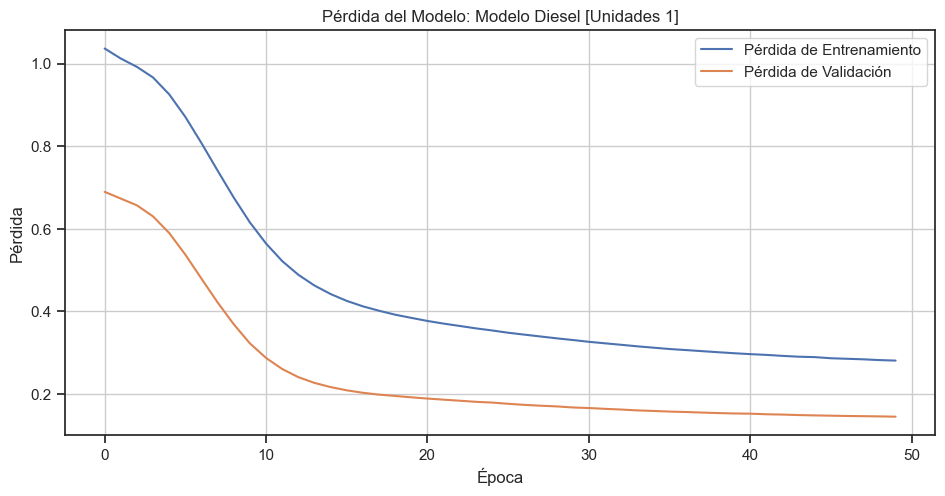

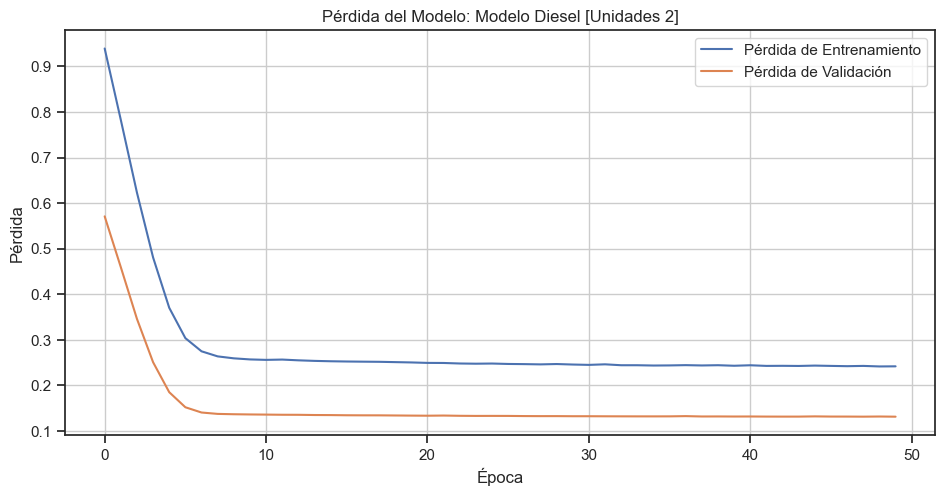

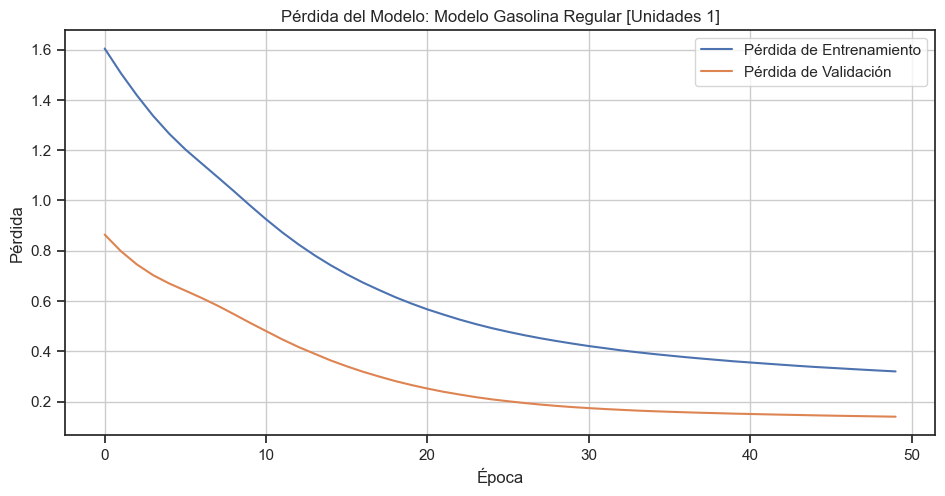

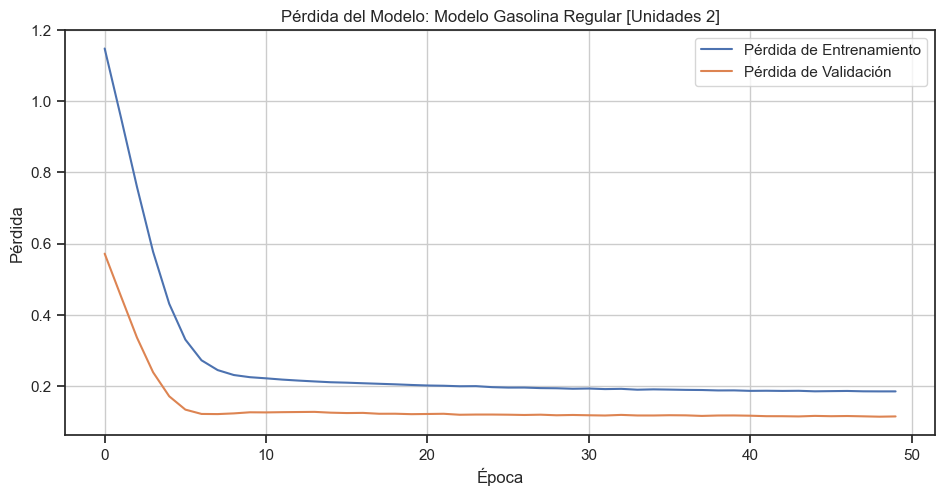

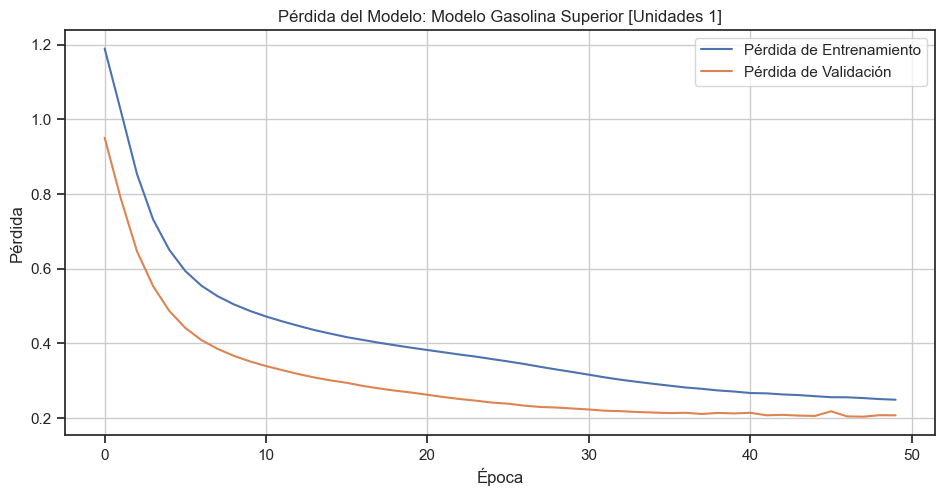

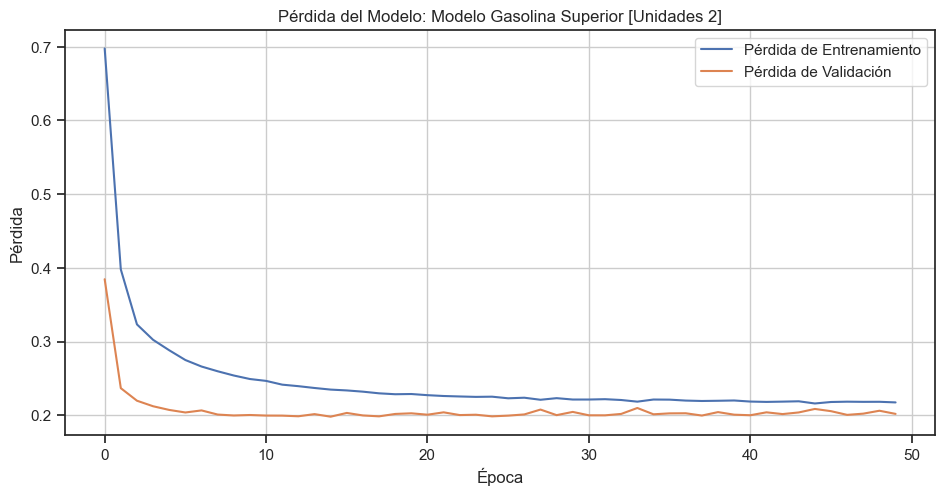

In [85]:

def graficar_historial(historial, nombre_modelo):
    """
    Grafica la pérdida de entrenamiento y validación a partir del historial del modelo.

    :param historial: El objeto de historial que se obtiene al entrenar el modelo.
    :param nombre_modelo: El nombre del modelo, usado para el título de la gráfica.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(historial['loss'], label='Pérdida de Entrenamiento')
    plt.plot(historial['val_loss'], label='Pérdida de Validación')
    plt.title(f'Pérdida del Modelo: {nombre_modelo}')
    plt.ylabel('Pérdida')
    plt.xlabel('Época')
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()

# Uso de la función
graficar_historial(historial_d1, 'Modelo Diesel [Unidades 1]')
graficar_historial(historial_d2, 'Modelo Diesel [Unidades 2]')
graficar_historial(historial_r1, 'Modelo Gasolina Regular [Unidades 1]')
graficar_historial(historial_r2, 'Modelo Gasolina Regular [Unidades 2]')
graficar_historial(historial_s1, 'Modelo Gasolina Superior [Unidades 1]')
graficar_historial(historial_s2, 'Modelo Gasolina Superior [Unidades 2]')


In [86]:
def evaluarModelo(modelo, nombre, xTrain, yTrain, xVal, yVal, xTest, yTest):
    print(f"🔍 Evaluando el modelo - {nombre}")

    lossTrain = modelo.evaluate(xTrain, yTrain, verbose=0)
    print(f"📊 Pérdida de Entrenamiento: {lossTrain:.4f}")

    lossVal = modelo.evaluate(xVal, yVal, verbose=0)
    print(f"📊 Pérdida de Validación: {lossVal:.4f}")

    lossTest = modelo.evaluate(xTest, yTest, verbose=0)
    print(f"📊 Pérdida de Prueba: {lossTest:.4f}\n")

def onlyLoadModelo(nombre_archivo):
    if os.path.exists(nombre_archivo):
        print(f"📂 Cargando modelo desde {nombre_archivo}")
        return load_model(nombre_archivo)
    else:
        print(f"❌ Modelo no encontrado")

modelo_d1 = onlyLoadModelo('modelo_diesel_1.h5')
modelo_d2 = onlyLoadModelo('modelo_diesel_2.h5')
modelo_r1 = onlyLoadModelo('modelo_regular_1.h5')
modelo_r2 = onlyLoadModelo('modelo_regular_2.h5')
modelo_s1 = onlyLoadModelo('modelo_superior_1.h5') 
modelo_s2 = onlyLoadModelo('modelo_superior_2.h5')
modelo_d1.compile(optimizer='adam', loss='mean_squared_error')  
modelo_d2.compile(optimizer='adam', loss='mean_squared_error')
modelo_r1.compile(optimizer='adam', loss='mean_squared_error')
modelo_r2.compile(optimizer='adam', loss='mean_squared_error')
modelo_s1.compile(optimizer='adam', loss='mean_squared_error')
modelo_s2.compile(optimizer='adam', loss='mean_squared_error')

evaluarModelo(modelo_d1, 'Diesel [Unidades 1]', x_trainD_3D, y_trainD, x_valD_3D, y_valD, x_testD_3D, y_testD)
evaluarModelo(modelo_d2, 'Diesel [Unidades 2]', x_trainD_3D, y_trainD, x_valD_3D, y_valD, x_testD_3D, y_testD)
evaluarModelo(modelo_r1, 'Gasolina Regular [Unidades 1]', x_trainR_3D, y_trainR, x_valR_3D, y_valR, x_testR_3D, y_testR)
evaluarModelo(modelo_r2, 'Gasolina Regular [Unidades 2]', x_trainR_3D, y_trainR, x_valR_3D, y_valR, x_testR_3D, y_testR)
evaluarModelo(modelo_s1, 'Gasolina Superior [Unidades 1]', x_trainS_3D, y_trainS, x_valS_3D, y_valS, x_testS_3D, y_testS)
evaluarModelo(modelo_s2, 'Gasolina Superior [Unidades 2]', x_trainS_3D, y_trainS, x_valS_3D, y_valS, x_testS_3D, y_testS)

📂 Cargando modelo desde modelo_diesel_1.h5
📂 Cargando modelo desde modelo_diesel_2.h5
📂 Cargando modelo desde modelo_regular_1.h5
📂 Cargando modelo desde modelo_regular_2.h5
📂 Cargando modelo desde modelo_superior_1.h5
📂 Cargando modelo desde modelo_superior_2.h5
🔍 Evaluando el modelo - Diesel [Unidades 1]
📊 Pérdida de Entrenamiento: 0.2785
📊 Pérdida de Validación: 0.1452
📊 Pérdida de Prueba: 0.2639

🔍 Evaluando el modelo - Diesel [Unidades 2]
📊 Pérdida de Entrenamiento: 0.2391
📊 Pérdida de Validación: 0.1313
📊 Pérdida de Prueba: 0.1974

🔍 Evaluando el modelo - Gasolina Regular [Unidades 1]
📊 Pérdida de Entrenamiento: 0.3171
📊 Pérdida de Validación: 0.1397
📊 Pérdida de Prueba: 0.0391

🔍 Evaluando el modelo - Gasolina Regular [Unidades 2]
📊 Pérdida de Entrenamiento: 0.1821
📊 Pérdida de Validación: 0.1142
📊 Pérdida de Prueba: 0.0326

🔍 Evaluando el modelo - Gasolina Superior [Unidades 1]
📊 Pérdida de Entrenamiento: 0.2474
📊 Pérdida de Validación: 0.2071
📊 Pérdida de Prueba: 0.0644

🔍 Eva